In [186]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import lime
import lime.lime_tabular

In [187]:
#data importation
import pandas as pd
import numpy as np

# Read the cleaned CSV file
fraud_data = pd.read_csv('CleanedFraudData.csv')

# Display the first few rows
fraud_data.head()


,Unnamed: 0,fraud_bool,income,name_email_similarity,salary,prev_address_months_count,current_address_months_count,customer_age,date_of_birth,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
0,2,0.0,0.8,0.996707,122830.0,9.0,14.0,40.0,1982-01-01,0.012316,-1.490386,AB,1095,4471.0,5472.0,5993.0,15.0,11.0,CA,89.0,1.0,BC,0.0,1.0,30.0,0.0,200.0,0.0,INTERNET,22.730559,windows,0.0,1.0,0.0,January,aol.com
1,3,0.0,0.6,0.475100,83960.0,11.0,14.0,30.0,1990-09-05,0.006991,-1.863101,AB,3483,14432.0,6755.0,5970.0,11.0,13.0,CA,90.0,1.0,BC,0.0,1.0,1.0,0.0,200.0,0.0,INTERNET,15.215816,linux,1.0,1.0,0.0,January,aol.com
2,6,0.0,0.2,0.773085,38585.0,22.0,4.0,40.0,1984-04-22,0.006919,-0.544676,AB,1998,11724.0,7864.0,6339.0,28.0,8.0,CA,72.0,1.0,BC,1.0,1.0,1.0,0.0,200.0,0.0,INTERNET,28.199923,x11,1.0,1.0,0.0,January,zoho.com
3,8,0.0,0.3,0.523655,40031.0,21.0,2.0,30.0,1992-11-08,0.035206,-0.955737,AB,1781,6980.0,4336.0,6625.0,2.0,10.0,CA,35.0,0.0,BC,1.0,0.0,2.0,0.0,200.0,0.0,INTERNET,5.329387,other,1.0,1.0,0.0,January,business.org
4,18,0.0,0.2,0.527751,37010.0,13.0,114.0,20.0,1999-09-25,0.003171,-0.848347,AB,4389,12256.0,5391.0,6331.0,1839.0,18.0,CA,49.0,0.0,BB,1.0,1.0,15.0,0.0,200.0,0.0,INTERNET,2.838194,windows,1.0,2.0,0.0,January,consulting.co


In [188]:
#shape of data
fraud_data.shape

(244191, 36)

In [189]:
# Data Types
fraud_data.dtypes

Unnamed: 0                            int64
fraud_bool                          float64
income                              float64
name_email_similarity               float64
salary                              float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
date_of_birth                        object
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                

In [190]:
# Removal of some redundant columns
fraud_data = fraud_data.drop(['name_email_similarity','salary','date_of_birth',
                              'zip_count_4w','income','Unnamed: 0'], axis=1)


In [191]:
# create cross tab for actual data
fraud_prop = pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop")/pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop").sum()
print(fraud_prop )

col_0         prop
fraud_bool        
0.0         0.9969
1.0         0.0031


In [192]:
pd.crosstab(index = fraud_data['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,243434
1.0,757


## Creating Train and Test data

In [193]:
train = fraud_data.groupby("fraud_bool").sample(n = 500, random_state = 1234)
test = fraud_data.loc[fraud_data.index.difference(train.index)]
train.head()

,fraud_bool,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain
156658,0.0,30.0,292.0,20.0,8.530328,31.862383,AA,10342.0,5998.0,5180.0,11.0,9.0,CA,91.0,1.0,BE,0.0,1.0,30.0,0.0,200.0,0.0,INTERNET,8.406942,other,0.0,1.0,0.0,May,yandex.com
63213,0.0,52.0,17.0,40.0,0.004717,-0.892632,AD,9698.0,4916.0,5617.0,0.0,12.0,CA,122.0,1.0,BC,1.0,0.0,21.0,0.0,200.0,0.0,INTERNET,3.214909,other,0.0,1.0,0.0,March,gmail.com
196385,0.0,20.0,0.0,30.0,1.221956,-0.683191,AB,3169.0,3642.0,4295.0,1.0,16.0,CB,253.0,1.0,BC,1.0,1.0,1.0,0.0,200.0,0.0,INTERNET,6.651120,other,1.0,1.0,0.0,July,yandex.com
97557,0.0,52.0,16.0,50.0,0.007483,-0.443474,AC,8974.0,5464.0,5191.0,0.0,4.0,CA,223.0,0.0,BB,1.0,1.0,-1.0,0.0,1000.0,0.0,INTERNET,5.246280,linux,1.0,1.0,0.0,March,consulting.co
181264,0.0,24.0,4.0,20.0,0.030740,-1.001902,AC,7054.0,3243.0,4373.0,0.0,6.0,CA,189.0,0.0,BA,1.0,0.0,-1.0,0.0,200.0,0.0,INTERNET,13.476022,other,0.0,1.0,0.0,June,finance.pro


In [194]:
pd.crosstab(index = train['fraud_bool'], columns = "count")



col_0,count
fraud_bool,
0.0,500
1.0,500


In [195]:
pd.crosstab(index = test['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,242934
1.0,257


In [196]:
# filling in number dtypes with median and flagging with missing 
train_o = train.copy()
num_cols = train_o.select_dtypes(include='number').columns

for col in num_cols:
    if train_o[col].isnull().any():
        # Create missing flag column
        train_o[f'{col}_was_missing'] = train_o[col].isnull().astype(int)

        # Impute with median
        median = train_o[col].median()
        train_o[col] = train_o[col].fillna(median)
print(train_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain'],
      dtype='object')


In [197]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(train_o.dtypes)


fraud_bool                          float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                float64
date_of_birth_distinct_emails_4w    float64
employment_status                    object
credit_risk_score                   float64
email_is_free                       float64
housing_status                       object
phone_home_valid                    float64
phone_mobile_valid                  float64
bank_months_count                   float64
has_other_cards                     float64
proposed_credit_limit               float64
foreign_request                     float64
source                          

In [198]:
# creating X and Y and creating dummies for categorical data 
predictors = train_o.drop(columns=['fraud_bool'])
predictors = pd.get_dummies(predictors, drop_first=True)
predictors = predictors.astype(float)

X = predictors
y = train_o['fraud_bool']

In [199]:
# using Pearson's square to sort data and determine association, 
# Use p-value of 0.002 depending on the data siize
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

# Fit SelectKBest for Categorical Variables
selector = SelectKBest(score_func=chi2, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cat, y)

# Create a DataFrame with feature names, Chi2-scores, and p-values
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cat_features = scores_cat_df[scores_cat_df['p_value'] < 0.002]['Feature']

# Fit SelectKBest for Continous Variables
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cont, y)

# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cont_features = scores_cont_df[scores_cont_df['p_value'] < 0.002]['Feature']

# Create a new DataFrame with only those selected columns
X_reduced = X[selected_cat_features.tolist() + selected_cont_features.tolist()]

X_reduced.head()

,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,payment_type_AC,employment_status_CB,employment_status_CF,housing_status_BB,device_os_other,device_os_windows,month_August,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,date_of_birth_distinct_emails_4w,credit_risk_score,proposed_credit_limit,device_distinct_emails_8w
156658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,30.0,292.0,20.0,31.862383,9.0,91.0,200.0,1.0
63213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,52.0,17.0,40.0,-0.892632,12.0,122.0,200.0,1.0
196385,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,20.0,0.0,30.0,-0.683191,16.0,253.0,200.0,1.0
97557,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,52.0,16.0,50.0,-0.443474,4.0,223.0,1000.0,1.0
181264,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,4.0,20.0,-1.001902,6.0,189.0,200.0,1.0


In [200]:
selected_cat_features

1         phone_home_valid
3          has_other_cards
4          foreign_request
5       keep_alive_session
7          payment_type_AC
9     employment_status_CB
13    employment_status_CF
14       housing_status_BB
21         device_os_other
22       device_os_windows
24            month_August
Name: Feature, dtype: object

In [201]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(X_reduced.dtypes)

phone_home_valid                    float64
has_other_cards                     float64
foreign_request                     float64
keep_alive_session                  float64
payment_type_AC                     float64
employment_status_CB                float64
employment_status_CF                float64
housing_status_BB                   float64
device_os_other                     float64
device_os_windows                   float64
month_August                        float64
prev_address_months_count           float64
current_address_months_count        float64
customer_age                        float64
intended_balcon_amount              float64
date_of_birth_distinct_emails_4w    float64
credit_risk_score                   float64
proposed_credit_limit               float64
device_distinct_emails_8w           float64
dtype: object


In [202]:
#remove variables with quasi separation 
def check_quasi_complete_separation(X, y):
    """
    Checks each categorical predictor in X for quasi-complete separation with respect to binary target y.
    
    Parameters:
    - X: pd.DataFrame of predictors (categorical variables)
    - y: pd.Series of binary target variable (e.g., 0/1 or True/False)
    
    Returns:
    - List of variable names that exhibit quasi-complete separation
    """
    problematic_vars = []

    for col in X.columns:
        ct = pd.crosstab(X[col], y)

        # Check if any category (row) has a zero in any outcome class
        if (ct == 0).any(axis=1).any():
            print(f"⚠️ Quasi-complete separation detected in '{col}'")
            print(ct)
            print()
            problematic_vars.append(col)

    return problematic_vars

In [203]:
# Create a new DataFrame with only those selected columns
X_cat_reduced = X_reduced[selected_cat_features]

problem_vars = check_quasi_complete_separation(X_cat_reduced, y)

In [204]:
X_reduced = X_reduced.drop(problem_vars, axis = 1)

In [205]:
#first model
import statsmodels.api as sm

X_reduced = sm.add_constant(X_reduced)

# Build Logistic Regression
model = sm.Logit(y, X_reduced)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.461940
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             fraud_bool   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      980
Method:                           MLE   Df Model:                           19
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                  0.3336
Time:                        00:33:36   Log-Likelihood:                -461.94
converged:                       True   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                 4.183e-86
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -2.8968      0.592     -4.89

In [206]:
#Stepwise selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_reduced.columns)

# Model
logr = LogisticRegression(max_iter = 1000, solver = 'newton-cg', penalty = None) 

# stepwise floating selection to find best subset of features
sfs = SFS(logr,
          k_features = "best", 
          forward = True,
          floating = True,
          scoring = 'roc_auc',
          cv = 10,
          verbose=2,
          n_jobs=-1)
       

sfs = sfs.fit(X_scaled_df, y)

# Get selected feature names
selected_featuresA = list(sfs.k_feature_names_)
print("Selected featuresA:", selected_featuresA)


[2026-01-23 00:33:36] Features: 1/20 -- score: 0.669
[2026-01-23 00:33:37] Features: 2/20 -- score: 0.7398
[2026-01-23 00:33:37] Features: 3/20 -- score: 0.7657999999999999
[2026-01-23 00:33:38] Features: 4/20 -- score: 0.7887200000000001
[2026-01-23 00:33:38] Features: 5/20 -- score: 0.8027599999999999
[2026-01-23 00:33:38] Features: 6/20 -- score: 0.8130000000000001
[2026-01-23 00:33:39] Features: 7/20 -- score: 0.8229999999999998
[2026-01-23 00:33:39] Features: 8/20 -- score: 0.82844
[2026-01-23 00:33:40] Features: 9/20 -- score: 0.8337600000000001
[2026-01-23 00:33:40] Features: 10/20 -- score: 0.83744
[2026-01-23 00:33:41] Features: 11/20 -- score: 0.84092
[2026-01-23 00:33:41] Features: 12/20 -- score: 0.8445600000000001
[2026-01-23 00:33:42] Features: 13/20 -- score: 0.84644
[2026-01-23 00:33:43] Features: 14/20 -- score: 0.84772
[2026-01-23 00:33:43] Features: 15/20 -- score: 0.8492000000000001
[2026-01-23 00:33:44] Features: 16/20 -- score: 0.8497600000000001
[2026-01-23 00:3

Selected featuresA: ['const', 'phone_home_valid', 'has_other_cards', 'keep_alive_session', 'payment_type_AC', 'employment_status_CB', 'employment_status_CF', 'housing_status_BB', 'device_os_other', 'device_os_windows', 'month_August', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'intended_balcon_amount', 'date_of_birth_distinct_emails_4w', 'proposed_credit_limit', 'device_distinct_emails_8w']



[2026-01-23 00:33:47] Features: 20/20 -- score: 0.8491199999999999

In [207]:
#Backward selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_reduced.columns)

# Model
logr = LogisticRegression(max_iter = 1000, solver = 'newton-cg', penalty = None) 

# stepwise floating selection to find best subset of features
sfs = SFS(logr,
          k_features = "best", 
          forward = True,
          floating = False,
          scoring = 'roc_auc',
          cv = 10,
          verbose=2,
          n_jobs=-1)
       

sfs = sfs.fit(X_scaled_df, y)

# Get selected feature names
selected_featuresB = list(sfs.k_feature_names_)
print("Selected featuresB:", selected_featuresB)


[2026-01-23 00:33:47] Features: 1/20 -- score: 0.669
[2026-01-23 00:33:48] Features: 2/20 -- score: 0.7398
[2026-01-23 00:33:48] Features: 3/20 -- score: 0.7657999999999999
[2026-01-23 00:33:48] Features: 4/20 -- score: 0.7887200000000001
[2026-01-23 00:33:49] Features: 5/20 -- score: 0.8027599999999999
[2026-01-23 00:33:49] Features: 6/20 -- score: 0.8130000000000001
[2026-01-23 00:33:50] Features: 7/20 -- score: 0.8229999999999998
[2026-01-23 00:33:50] Features: 8/20 -- score: 0.82844
[2026-01-23 00:33:50] Features: 9/20 -- score: 0.8337600000000001
[2026-01-23 00:33:51] Features: 10/20 -- score: 0.83744
[2026-01-23 00:33:51] Features: 11/20 -- score: 0.84092
[2026-01-23 00:33:51] Features: 12/20 -- score: 0.8445600000000001
[2026-01-23 00:33:51] Features: 13/20 -- score: 0.84644
[2026-01-23 00:33:51] Features: 14/20 -- score: 0.84772
[2026-01-23 00:33:52] Features: 15/20 -- score: 0.8492000000000001
[2026-01-23 00:33:52] Features: 16/20 -- score: 0.8497600000000001

Selected featuresB: ['const', 'phone_home_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'payment_type_AC', 'employment_status_CB', 'employment_status_CF', 'housing_status_BB', 'device_os_other', 'device_os_windows', 'month_August', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'intended_balcon_amount', 'date_of_birth_distinct_emails_4w', 'proposed_credit_limit', 'device_distinct_emails_8w']



[2026-01-23 00:33:52] Features: 17/20 -- score: 0.8497600000000001
[2026-01-23 00:33:52] Features: 18/20 -- score: 0.84956
[2026-01-23 00:33:52] Features: 19/20 -- score: 0.8500400000000001
[2026-01-23 00:33:52] Features: 20/20 -- score: 0.8491199999999999

In [208]:
common_features = list(set(selected_featuresA) & set(selected_featuresB))
common_features.sort()


In [209]:
X_selected = X_reduced[common_features].copy()

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

print(vif_data)

                             feature        VIF
0                              const  41.608417
1       current_address_months_count   1.060090
2                       customer_age   1.356936
3   date_of_birth_distinct_emails_4w   1.334235
4          device_distinct_emails_8w   1.072531
5                    device_os_other   1.246613
6                  device_os_windows   1.295663
7               employment_status_CB   1.045870
8               employment_status_CF   1.046770
9                    has_other_cards   1.055451
10                 housing_status_BB   1.074241
11            intended_balcon_amount   1.099499
12                keep_alive_session   1.085805
13                      month_August   1.065780
14                   payment_type_AC   1.100072
15                  phone_home_valid   1.068201
16         prev_address_months_count   1.073869
17             proposed_credit_limit   1.081881


In [210]:
X_selected = X_reduced[common_features].copy()
X_selected.shape

(1000, 18)

In [211]:
y =train_o['fraud_bool']
y.shape

(1000,)

In [212]:
# Initial model using logit 
import statsmodels.api as sm



# Add constant (intercept) column
y =train_o['fraud_bool']

# Build Logistic Regression model
model = sm.Logit(y, X_selected)
result = model.fit()

# Display summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.464953
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             fraud_bool   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      982
Method:                           MLE   Df Model:                           17
Date:                Fri, 23 Jan 2026   Pseudo R-squ.:                  0.3292
Time:                        00:33:52   Log-Likelihood:                -464.95
converged:                       True   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                 2.827e-86
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -2.7181      0.574     -4.73

In [213]:
#Based on oversampling
weight_1 = 1
weight_0 = (243434/757) / (500/500)

In [214]:
# final model using GLM and the weight 
import statsmodels.api as sm

# Assign weights based on fraud label
train_o['weight'] = train_o['fraud_bool'].replace({1: weight_1, 0: weight_0}).astype(float)

# Add constant to predictors

# Build weighted logistic regression model
model_w = sm.GLM(
    y,
    X_selected,
    family=sm.families.Binomial(),
    freq_weights=train_o['weight']
)

# Fit the model
result_w = model_w.fit()

# Display summary
print(result_w.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                 1000
Model:                            GLM   Df Residuals:                161270.64
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2699.1
Date:                Fri, 23 Jan 2026   Deviance:                       5398.1
Time:                        00:33:52   Pearson chi2:                 3.51e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.7476
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [215]:
train_o['pred_prob'] = result_w.predict(X_selected)
train_o['pred_prob']

156658    1.636064e-03
63213     3.643887e-04
196385    1.341590e-05
97557     6.621220e-04
181264    2.308251e-04
90416     3.364331e-04
28899     5.631492e-04
170819    7.441784e-04
217755    4.962481e-03
7966      1.202990e-04
155876    1.119040e-03
128187    3.105895e-04
204932    2.679340e-03
126817    1.063213e-03
228203    1.741383e-03
68947     6.532687e-04
54758     8.557807e-04
38351     2.599406e-02
227234    1.650857e-02
189381    2.078957e-02
239263    4.137202e-03
106924    5.840775e-03
84328     8.559715e-04
106350    2.485672e-04
122721    2.657457e-02
4420      9.080264e-03
100885    4.674871e-04
135270    1.504157e-02
10322     1.594058e-02
149361    2.738467e-03
8451      7.442094e-03
147301    3.715594e-03
230678    4.232892e-04
476       8.363791e-05
31233     2.725420e-04
213320    3.190316e-05
72624     4.330585e-04
153114    9.662003e-03
58757     3.594201e-05
205506    5.913991e-05
148443    6.237111e-04
16931     7.085903e-05
216507    1.542933e-03
143333    2

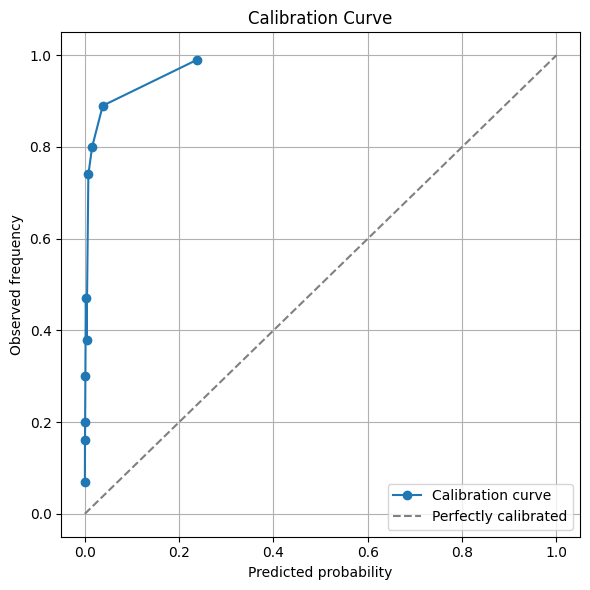

In [216]:
# calibration 
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# y_true: true binary outcomes (0 or 1)
# y_prob: predicted probabilities from your classifier (e.g., model.predict_proba[:, 1])

# Compute calibration curve
prob_true, prob_pred = calibration_curve(train_o['fraud_bool'], train_o['pred_prob'], n_bins=10, strategy='quantile')

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Diagnosis

In [217]:
#determining best threshlold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import pandas as pd

# Ensure there are no NaNs and both arrays are numeric
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)

# Check for constant values (this causes roc_curve to fail)
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Build Youden’s index table
youden = pd.DataFrame({
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
})

# Sort by Youden’s index
youden = youden.sort_values(by='Youden', ascending=False).reset_index(drop=True)

# Optional: show best cutoff
print("Best threshold:", youden.loc[0, 'Cut-off'])
youden.head()


Best threshold: 0.004161775087239017


,TPR,FPR,Cut-off,Youden
0,0.714,0.136,0.004162,0.578
1,0.718,0.140,0.004127,0.578
2,0.694,0.118,0.004841,0.576
3,0.730,0.156,0.003737,0.574
4,0.714,0.140,0.004129,0.574


In [218]:
import pandas as pd

train_o['pred'] = train_o['pred_prob'].map(lambda x: 1 if x > 0.004161775087239017 else 0)

pd.crosstab(train_o['fraud_bool'], train_o['pred'])

pred,0,1
fraud_bool,,
0.0,432,68
1.0,144,356


In [219]:
# Taking into account the cost 
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np

# True labels and predicted probabilities
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)

# --- Business Costs ---
C_FN = 1200                     # Cost of false negative (missed fraud)
C_FP_values = np.arange(700, 1001, 100)  # Costs of false positive (700 → 1000)

# --- Check for constant target ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Base counts ---
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# --- Build results ---
results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# Compute cost for each FP cost level
for C_FP in C_FP_values:
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )

# --- Find best threshold for each FP cost ---
best_thresholds = []
for C_FP in C_FP_values:
    col = f'Cost_FP{C_FP}'
    idx_min = results[col].idxmin()
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': results.loc[idx_min, 'Threshold'],
        'Min_Cost': results.loc[idx_min, col],
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

print("✅ Optimal thresholds by false positive cost:")
print(best_df)



✅ Optimal thresholds by false positive cost:
   C_FP  Best_Threshold  Min_Cost    TPR    FPR
0   700        0.001277  207000.0  0.872  0.372
1   800        0.003737  224400.0  0.730  0.156
2   900        0.003737  232200.0  0.730  0.156
3  1000        0.004127  239200.0  0.718  0.140


✅ Optimal thresholds and cost savings vs baseline (threshold = 0.5):

   C_FP  Best_Threshold  Baseline_Cost  Min_Cost   Savings   TPR   FPR
0   700             0.0       598800.0  207000.0  391800.0  0.87  0.37
1   800             0.0       598800.0  224400.0  374400.0  0.73  0.16
2   900             0.0       598800.0  232200.0  366600.0  0.73  0.16
3  1000             0.0       598800.0  239200.0  359600.0  0.72  0.14


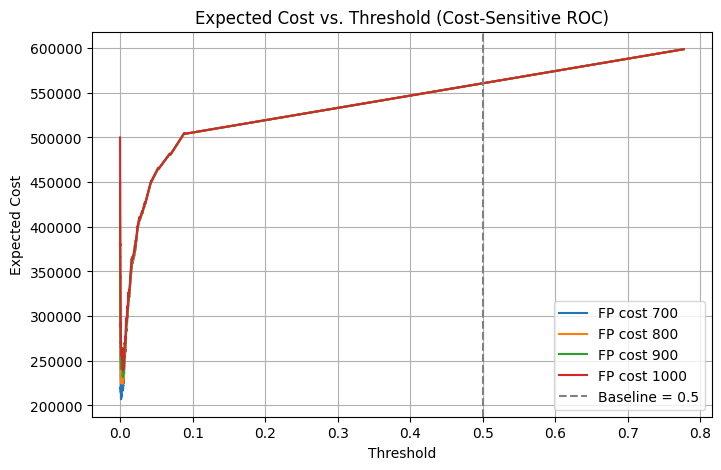

In [220]:
# Base line compared to adjusting for cost
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Inputs ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)

# --- Business Costs ---
C_FN = 1200                        # Cost of missing a fraud
C_FP_values = np.arange(700, 1001, 100)  # Cost range for false positives (700–1000)
baseline_threshold = 0.5           # Your current operational cutoff

# --- Checks ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# --- Compute cost and baseline savings for each FP cost ---
best_thresholds = []

# Baseline performance at threshold 0.5
baseline_idx = np.argmin(np.abs(thresholds - baseline_threshold))
baseline_tpr = tpr[baseline_idx]
baseline_fpr = fpr[baseline_idx]

for C_FP in C_FP_values:
    # Expected cost at each threshold
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )
    
    # Baseline cost
    baseline_cost = (
        (C_FP * baseline_fpr * total_neg) + 
        (C_FN * (1 - baseline_tpr) * total_pos)
    )
    
    # Find minimum cost
    idx_min = results[f'Cost_FP{C_FP}'].idxmin()
    min_cost = results.loc[idx_min, f'Cost_FP{C_FP}']
    best_threshold = results.loc[idx_min, 'Threshold']
    
    # Savings = baseline_cost - min_cost
    savings = baseline_cost - min_cost
    
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': best_threshold,
        'Baseline_Cost': baseline_cost,
        'Min_Cost': min_cost,
        'Savings': savings,
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

# --- Display results ---
print("✅ Optimal thresholds and cost savings vs baseline (threshold = 0.5):\n")
print(best_df.round(2))

# --- Plot cost curves ---
plt.figure(figsize=(8, 5))
for C_FP in C_FP_values:
    plt.plot(results['Threshold'], results[f'Cost_FP{C_FP}'], label=f'FP cost {C_FP}')
plt.axvline(baseline_threshold, color='gray', linestyle='--', label='Baseline = 0.5')
plt.xlabel('Threshold')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs. Threshold (Cost-Sensitive ROC)')
plt.legend()  # fixed from plt.lege
plt.grid(True)
plt.show()


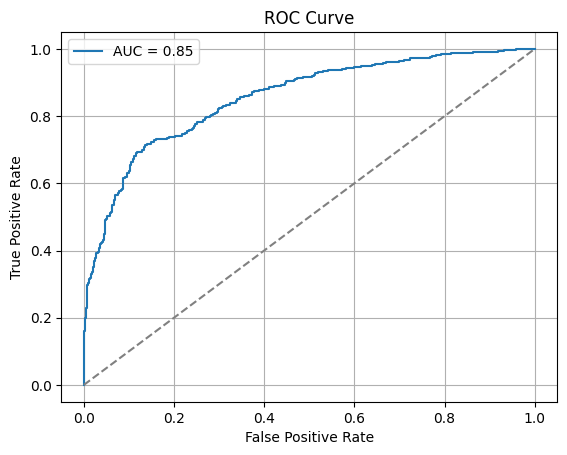

In [221]:
# Roc Curve
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(train_o['fraud_bool'], train_o['pred_prob'])

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

✅ Cost-Optimized Threshold (C_FP = 820)
Optimal Threshold : 0.0037
True Positive Rate: 0.7300
False Positive Rate: 0.1560
Minimum Expected Cost: $225,960.00


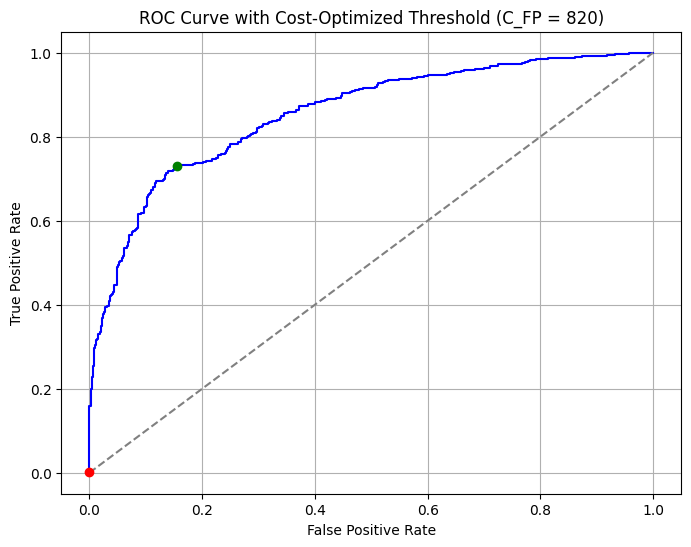

In [222]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- True labels and predicted probabilities ---
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)

# --- ROC curve for standard model (all thresholds) ---
fpr_model, tpr_model, thresholds_model = roc_curve(y_true, y_score)
auc_model = roc_auc_score(y_true, y_score)

# --- Business cost setup ---
C_FN = 1200   # Cost of false negative (missed fraud)
C_FP = 820    # Cost of false positive (wrongly flagged as fraud)

# --- Class counts ---
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# --- Compute total business cost for each threshold ---
costs = (C_FP * fpr_model * total_neg) + (C_FN * (1 - tpr_model) * total_pos)

# --- Identify optimal threshold minimizing total cost ---
idx_min = np.argmin(costs)
optimal_threshold = thresholds_model[idx_min]
optimal_fpr = fpr_model[idx_min]
optimal_tpr = tpr_model[idx_min]
optimal_cost = costs[idx_min]

# --- Print results ---
print("✅ Cost-Optimized Threshold (C_FP = 820)")
print(f"Optimal Threshold : {optimal_threshold:.4f}")
print(f"True Positive Rate: {optimal_tpr:.4f}")
print(f"False Positive Rate: {optimal_fpr:.4f}")
print(f"Minimum Expected Cost: ${optimal_cost:,.2f}")

# --- Plot ROC curves ---
plt.figure(figsize=(8, 6))

# Standard ROC curve
plt.plot(fpr_model, tpr_model, label=f"Model (AUC = {auc_model:.3f})", color='blue')

# Baseline threshold = 0.5 marker
baseline_idx = np.argmin(np.abs(thresholds_model - 0.5))
plt.scatter(
    fpr_model[baseline_idx],
    tpr_model[baseline_idx],
    color='red',
    label=f"Baseline threshold = 0.5",
    zorder=5
)

# Cost-optimized threshold marker
plt.scatter(
    optimal_fpr,
    optimal_tpr,
    color='green',
    label=f"Cost-optimal threshold = {optimal_threshold:.3f} (C_FP = 820)",
    zorder=5
)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Cost-Optimized Threshold (C_FP = 820)")
# plt.legend("cost-Optimized Threshold (C_FP = 820)
# Optimal Threshold : 0.3905
# True Positive Rate: 0.8636
# False Positive Rate: 0.2874
# Minimum Expected Cost: $1,996,740.00")

plt.grid(True)
plt.show()


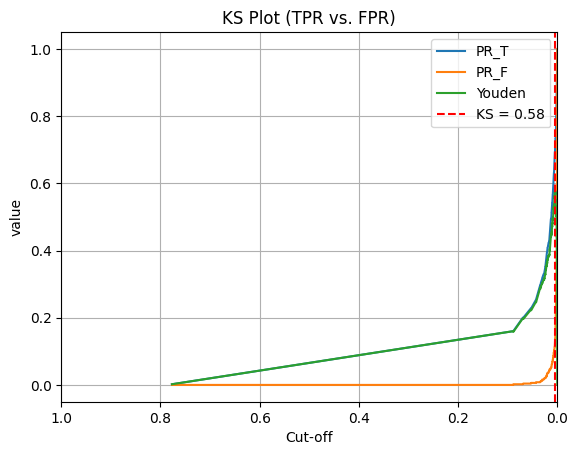

In [223]:
# KS plot 
import seaborn as sns

fpr, tpr, thresholds = roc_curve(train_o['fraud_bool'], train_o['pred_prob'])

# Create the Youden DataFrame
youden = pd.DataFrame({
    'Cut-off': thresholds,
    'TPR': tpr,
    'FPR': fpr,
    'Youden': tpr - fpr
})

# Sort by Cut-off and rename
youden = youden.sort_values(by='Cut-off', ascending=True)

ks_stat = youden.rename(columns={'TPR': 'PR_T', 'FPR': 'PR_F'})
ks_stat = ks_stat.melt(id_vars='Cut-off', var_name='PR', value_name='value')

ks_val = (youden['TPR'] - youden['FPR']).max()
ks_cutoff = youden.loc[(youden['TPR'] - youden['FPR']).idxmax(), 'Cut-off']

# Plot
sns.lineplot(x='Cut-off', y='value', hue='PR', data=ks_stat)
plt.xlim(1, 0)
plt.title("KS Plot (TPR vs. FPR)")
plt.grid(True)
plt.axvline(x=ks_cutoff, linestyle='--', color='red', label=f'KS = {ks_val:.2f}')
plt.legend()
plt.show()


In [224]:
# Precision, Recall, Cut-off, F1

from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

precision = np.array([])
recall = np.array([])
f1score = np.array([])

for y in range(100):
  train_o['pred'] = train_o['pred_prob'].map(lambda x: 1 if x > y/100 else 0)
  value_p = precision_score(train_o['fraud_bool'], train_o['pred'])
  precision = np.append(precision, value_p)
  value_r = recall_score(train_o['fraud_bool'], train_o['pred'])
  recall = np.append(recall, value_r)
  value_f = f1_score(train_o['fraud_bool'], train_o['pred'])
  f1score = np.append(f1score, value_f)

data = {'Precision': precision, 'Recall': recall, 'Cut-off': range(100), 'F1': f1score}
f1_s = pd.DataFrame(data)

f1_s.sort_values(by = ['F1'], ascending = False)

/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/appij25/.local/lib/python

,Precision,Recall,Cut-off,F1
1,0.888889,0.544,1,0.674938
0,0.500000,1.000,0,0.666667
2,0.922018,0.402,2,0.559889
3,0.952096,0.318,3,0.476762
4,0.972028,0.278,4,0.432348
5,0.975000,0.234,5,0.377419
6,0.981132,0.208,6,0.343234
7,0.990000,0.198,7,0.330000
8,0.988636,0.174,8,0.295918
9,1.000000,0.158,9,0.272884


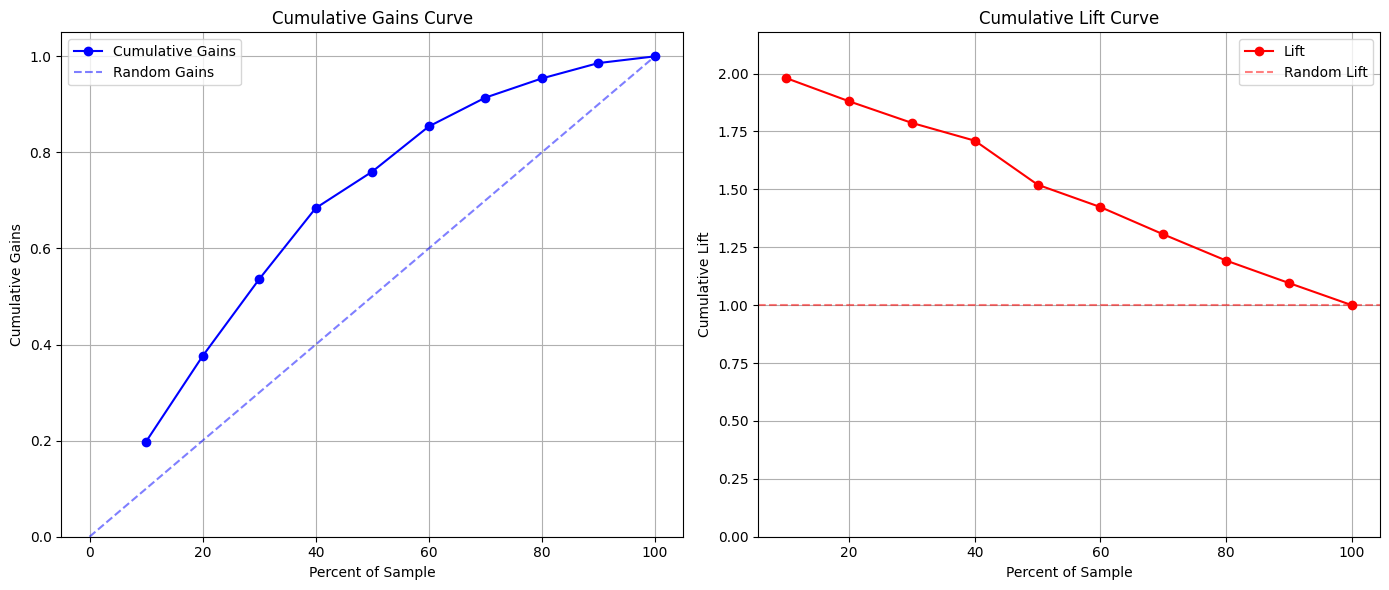

In [225]:
# Gains and lift Graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lift_and_gains(y_true, y_proba, n_bins=10):
    """
    Plot Lift and Cumulative Gains curves.
    
    Parameters:
    - y_true: array-like, true binary labels (0/1)
    - y_proba: array-like, predicted probabilities for the positive class
    - n_bins: number of bins/deciles to split data
    
    Returns:
    - None (plots the curves)
    """
    df = pd.DataFrame({
        'y_true': y_true,
        'y_proba': y_proba
    })
    
    # Sort descending by predicted probability
    df = df.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
    
    # Add cumulative counts
    df['cum_total'] = np.arange(1, len(df) + 1)
    df['cum_positives'] = df['y_true'].cumsum()
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    # Cumulative Gains: % positives captured vs % samples
    df['cum_gains'] = df['cum_positives'] / total_positives
    
    # Lift: (cumulative gains) / (cumulative % of sample)
    df['cum_lift'] = df['cum_gains'] / (df['cum_total'] / total_samples)
    
    # Sample points for plotting (deciles)
    cutoffs = np.linspace(0, total_samples, n_bins + 1, dtype=int)
    cutoffs = cutoffs[cutoffs > 0]  # remove zero
    plot_points = df.loc[cutoffs - 1, ['cum_total', 'cum_gains', 'cum_lift']].copy()
    plot_points['percent_samples'] = plot_points['cum_total'] / total_samples * 100
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Cumulative Gains
    axes[0].plot(plot_points['percent_samples'], plot_points['cum_gains'], marker='o', color='blue', label='Cumulative Gains')
    axes[0].plot([0, 100], [0, 1], linestyle='--', color='blue', alpha=0.5, label='Random Gains')
    axes[0].set_xlabel('Percent of Sample')
    axes[0].set_ylabel('Cumulative Gains')
    axes[0].set_title('Cumulative Gains Curve')
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(True)
    axes[0].legend()
    
    # Plot Lift
    axes[1].plot(plot_points['percent_samples'], plot_points['cum_lift'], marker='o', color='red', label='Lift')
    axes[1].axhline(1, linestyle='--', color='red', alpha=0.5, label='Random Lift')
    axes[1].set_xlabel('Percent of Sample')
    axes[1].set_ylabel('Cumulative Lift')
    axes[1].set_title('Cumulative Lift Curve')
    axes[1].set_ylim(0, plot_points['cum_lift'].max() * 1.1)
    axes[1].grid(True)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Example:
plot_lift_and_gains(train_o['fraud_bool'], train_o['pred_prob'])


## Transforming the test 

In [226]:
test_o= test.copy()
num_cols_test = test_o.select_dtypes(include='number').columns

for col in num_cols_test:
    if test_o[col].isnull().any():
        # Create missing flag column
        test_o[f'{col}_was_missing'] = test_o[col].isnull().astype(int)

        # Impute with median
        median = test_o[col].median()
        test_o[col] = test_o[col].fillna(median)
print(test_o.columns)

Index(['fraud_bool', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain', 'velocity_6h_was_missing'],
      dtype='object')


In [227]:
predictors_test = test_o.drop(columns=['fraud_bool'])
predictors_test = pd.get_dummies(predictors_test, drop_first=True)
predictors_test = predictors_test.astype(float)

X_test = predictors_test
y_test = test_o['fraud_bool']
X_test.head()

,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,velocity_6h_was_missing,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_TELEAPP,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,month_August,month_February,month_January,month_July,month_June,month_March,month_May,email_domain_aol.com,email_domain_business.org,email_domain_company.com,email_domain_consulting.co,email_domain_finance.pro,email_domain_gmail.com,email_domain_gmx.com,email_domain_hotmail.com,email_domain_icloud.com,email_domain_lawfirm.legal,email_domain_outlook.com,email_domain_protonmail.com,email_domain_startup.biz,email_domain_tech.info,email_domain_work.net,email_domain_yahoo.com,email_domain_yandex.com,email_domain_zoho.com
0,9.0,14.0,40.0,0.012316,-1.490386,4471.0,5472.0,5993.0,15.0,11.0,89.0,1.0,0.0,1.0,30.0,0.0,200.0,0.0,22.730559,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.0,14.0,30.0,0.006991,-1.863101,14432.0,6755.0,5970.0,11.0,13.0,90.0,1.0,0.0,1.0,1.0,0.0,200.0,0.0,15.215816,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,4.0,40.0,0.006919,-0.544676,11724.0,7864.0,6339.0,28.0,8.0,72.0,1.0,1.0,1.0,1.0,0.0,200.0,0.0,28.199923,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,21.0,2.0,30.0,0.035206,-0.955737,6980.0,4336.0,6625.0,2.0,10.0,35.0,0.0,1.0,0.0,2.0,0.0,200.0,0.0,5.329387,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,114.0,20.0,0.003171,-0.848347,12256.0,5391.0,6331.0,1839.0,18.0,49.0,0.0,1.0,1.0,15.0,0.0,200.0,0.0,2.838194,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
import pandas as pd
from sklearn.metrics import (
    mean_absolute_error, log_loss, brier_score_loss,
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score
)

# --- Align test features with training features ---
# X_selected: columns used in training
# X_reduced_test: selected features in test set
common_features = [f for f in common_features if f != 'const']

X_test1 = X_test[common_features].copy()
X_test1 = sm.add_constant(X_test1, has_constant='add')

# --- Predict probabilities using weighted logistic model ---
y_pred_prob = result_w.predict(X_test1)

X_test1.head()

,const,current_address_months_count,customer_age,date_of_birth_distinct_emails_4w,device_distinct_emails_8w,device_os_other,device_os_windows,employment_status_CB,employment_status_CF,has_other_cards,housing_status_BB,intended_balcon_amount,keep_alive_session,month_August,payment_type_AC,phone_home_valid,prev_address_months_count,proposed_credit_limit
0,1.0,14.0,40.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.490386,0.0,0.0,0.0,0.0,9.0,200.0
1,1.0,14.0,30.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.863101,1.0,0.0,0.0,0.0,11.0,200.0
2,1.0,4.0,40.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.544676,1.0,0.0,0.0,1.0,22.0,200.0
3,1.0,2.0,30.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.955737,1.0,0.0,0.0,1.0,21.0,200.0
4,1.0,114.0,20.0,18.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.848347,1.0,0.0,0.0,1.0,13.0,200.0


In [240]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, confusion_matrix, classification_report
)

# --- Convert probabilities to binary predictions using best threshold ---
best_threshold = 0.004161775087239017  # optimal threshold
y_pred_binary = (y_pred_prob >= best_threshold).astype(int)

# --- Classification metrics ---
accuracy = accuracy_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_prob)   # uses probabilities, not binary
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# --- Display results ---
print("====== CLASSIFICATION PERFORMANCE (BINARY TARGET) ======")
print(f"Best Threshold: {best_threshold:.6f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\n====== CONFUSION MATRIX ======")
print(confusion_matrix(y_test, y_pred_binary))

print("\n====== CLASSIFICATION REPORT ======")
print(classification_report(y_test, y_pred_binary, digits=4))


====== CLASSIFICATION PERFORMANCE (BINARY TARGET) ======
Best Threshold: 0.004162
Accuracy: 0.8204
ROC-AUC: 0.8231
Precision: 0.0038
Recall: 0.6537
F1 Score: 0.0076

====== CONFUSION MATRIX ======
[[199357  43577]
 [    89    168]]

====== CLASSIFICATION REPORT ======
              precision    recall  f1-score   support

         0.0     0.9996    0.8206    0.9013    242934
         1.0     0.0038    0.6537    0.0076       257

    accuracy                         0.8204    243191
   macro avg     0.5017    0.7372    0.4545    243191
weighted avg     0.9985    0.8204    0.9003    243191

